# MY IMPLEMENTATION OF THE SRGAN:
1. In this Implimentation of SRGAN I am leaving out BatchNormalisation as it causes a lot of unwanted problems during model training.
2. I am going to break the image into four parts and pass it to the discriminator as a batch of 4 and I feel like it should work because my device wont be able to compute the whole image at one go. Plus breaking the images into multiple smaller images will result in faster discriminating and generating time.
3. Paper Site: https://arxiv.org/abs/1609.04802
4. DIV2K Dataset Website: https://data.vision.ee.ethz.ch/cvl/DIV2K/
5. After breaking the images I was getting lines at the border so changing the type of padding helped with the removal of those lines.
6. SRGAN generator doesn't work unless and untill the generator has been taught on the Imagenet 1k dataset.

#### MATHEMATICAL REASONING FOR BREAKING THE IMAGE INTO 16 PARTS
    
    1. Lets say we have an image of size (3,1356,2040) and a kernel of size (64,3,3) [Channels first] then effectively:
    Number of operations = 3*1356*2040*64*3*3 = 4,78,00,62,720
    
    2. Now lets say we divide this image into 4 smaller parts each of size (3,339,510) and a kernel of size (64,3,3) [Channels first] then effectively:
    Number of operations = 3*339*510*64*3*3 = 29,87,53,920
    * Now effectively to it would take us 4 * 29,87,53,920 operations
    ((1,19,50,15,680/4,78,00,62,720)*100) = 25%
    Which means it effectively takes 75% lesser computations than a full size image
    
    3. Now lets divide the smaller image into 4 more smaller parts each of size (3,85,128) and a kernel of size (64,3,3) [Channels first] then effectively:
    Number of operations = 3*85*128*64*3*3 = 1,88,00,640
    Now effectively to it would take us 16 * 1,88,00,640 operations
    * ((30,08,10,240/4,78,00,62,720)*100) = 6.293%
    Which means it effectively takes 93.707% lesser computations than a full size image [averaged out would at least be 90% lesser computations] and 
    * ((30,08,10,240/1,19,50,15,680)*100) = 25.172%
    Which means it effectively takes 74.278% lesser computations than a full size image/4 [averaged out would at least be 70% lesser computations]

In [ ]:
import torch
import torch.nn as nn 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
torch.cuda.empty_cache()

In [ ]:
load_saved_model = True

## CHECKING OUT THE DATASET

torch.Size([1356, 2040, 3])


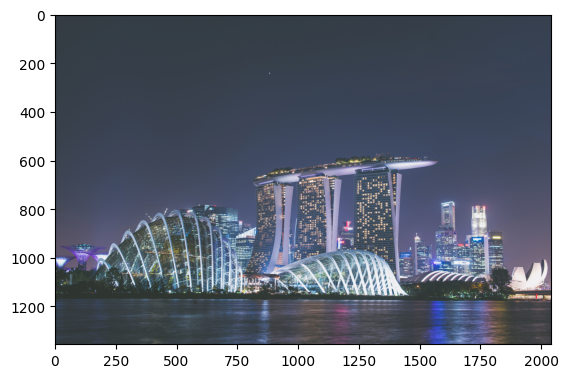

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_HR\DIV2K_valid_HR\0814.png')
img = torch.Tensor(img)
print(img.shape)
plt.imshow(img)

torch.Size([339, 510, 3])


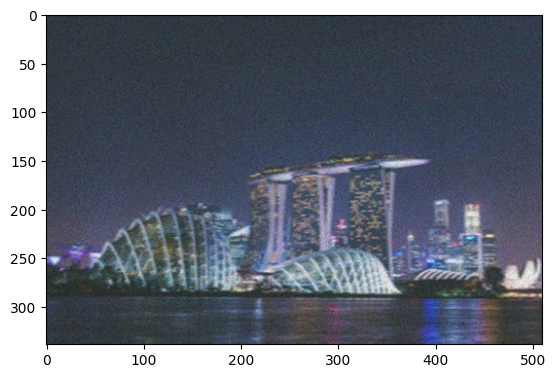

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_difficult\DIV2K_valid_LR_difficult\0814x4d.png')
img = torch.Tensor(img)
print(img.shape)
plt.imshow(img)

torch.Size([339, 510, 3])


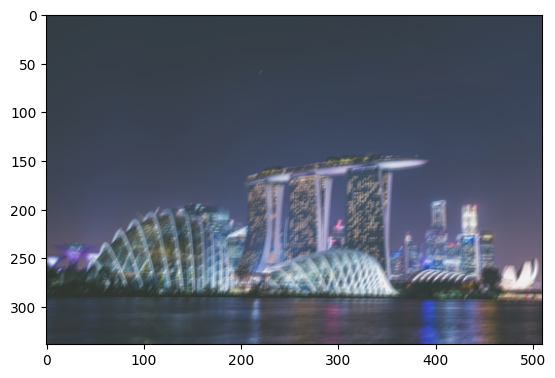

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_unknown_X4\DIV2K_valid_LR_unknown\X4\0814x4.png')
img = torch.Tensor(img)
print(img.shape)
plt.imshow(img)

## Breaking down the images of LR into 4 pieces to make the processing faster

In [ ]:
def Image_breakdown_further(img,lr=True):
    if lr:
        img_mini_batch = []
        h = img.shape[1]/2
        w = img.shape[2]/2
        
        if (h-int(h) != 0):
            h1 = int(h - .5)
            h2 = int(h + .5)
        else:
            h1 = int(h)
            h2 = int(h)
        
        if (w-int(w) != 0):
            w1 = int(w - .5)
            w2 = int(w + .5)
        else:
            w1 = int(w)
            w2 = int(w)
    else:
        img_mini_batch = []
        h = img.shape[1]/2
        w = img.shape[2]/2
        h = h/4
        w = w/4
        
        if (h-int(h) != 0):
            h1 = int(h - .5)*4
            h2 = int(h + .5)*4
        else:
            h1 = int(h)*4
            h2 = int(h)*4
        
        if (w-int(w) != 0):
            w1 = int(w - .5)*4
            w2 = int(w + .5)*4
        else:
            w1 = int(w)*4
            w2 = int(w)*4
        
    top_left = img[ :, :h1, :w1]
    top_right = img[ :, :h1, w1:w1+w2]
    bottom_left = img[ :, h1:h1+h2, :w1]
    bottom_right = img[ :, h1:h1+h2, w1:w1+w2]
    img_mini_batch = [top_left,top_right,bottom_left,bottom_right]
    return img_mini_batch

In [ ]:
def Image_breakdown(img, lr=True):
    if lr:
        img_mini_batch = []
        h = img.shape[1]/2
        w = img.shape[2]/2
        
        if (h-int(h) != 0):
            h1 = int(h - .5)
            h2 = int(h + .5)
        else:
            h1 = int(h)
            h2 = int(h)
        
        if (w-int(w) != 0):
            w1 = int(w - .5)
            w2 = int(w + .5)
        else:
            w1 = int(w)
            w2 = int(w)
    else:
        img_mini_batch = []
        h = img.shape[1]/2
        w = img.shape[2]/2
        h = h/4
        w = w/4
        
        if (h-int(h) != 0):
            h1 = int(h - .5)*4
            h2 = int(h + .5)*4
        else:
            h1 = int(h)*4
            h2 = int(h)*4
        
        if (w-int(w) != 0):
            w1 = int(w - .5)*4
            w2 = int(w + .5)*4
        else:
            w1 = int(w)*4
            w2 = int(w)*4
        
    top_left = img[ :, :h1, :w1]
    top_right = img[ :, :h1, w1:w1+w2]
    bottom_left = img[ :, h1:h1+h2, :w1]
    bottom_right = img[ :, h1:h1+h2, w1:w1+w2]
    img_mini_batch = [top_left,top_right,bottom_left,bottom_right]
    img_16_mini_batch = []
    to_be_returned = []
    
    for i in img_mini_batch:
        x = Image_breakdown_further(i,lr)
        for j in x:
            img_16_mini_batch.append(j)
    
    positions_of_mini_images = [0,1,4,5,2,3,6,7,8,9,12,13,10,11,14,15]
    for i in range(0,16):
        to_be_returned.append(img_16_mini_batch[positions_of_mini_images[i]])
    
    return to_be_returned

#### TESTING THE WORKING OF THE BREAKING DOWN OF IMAGES ON THE REAL HIGH RESOLUTION IMAGE

torch.Size([336, 508, 3])
torch.Size([336, 512, 3])
torch.Size([336, 508, 3])
torch.Size([336, 512, 3])
torch.Size([340, 508, 3])
torch.Size([340, 512, 3])
torch.Size([340, 508, 3])
torch.Size([340, 512, 3])
torch.Size([340, 508, 3])
torch.Size([340, 512, 3])
torch.Size([340, 508, 3])
torch.Size([340, 512, 3])
torch.Size([340, 508, 3])
torch.Size([340, 512, 3])
torch.Size([340, 508, 3])
torch.Size([340, 512, 3])


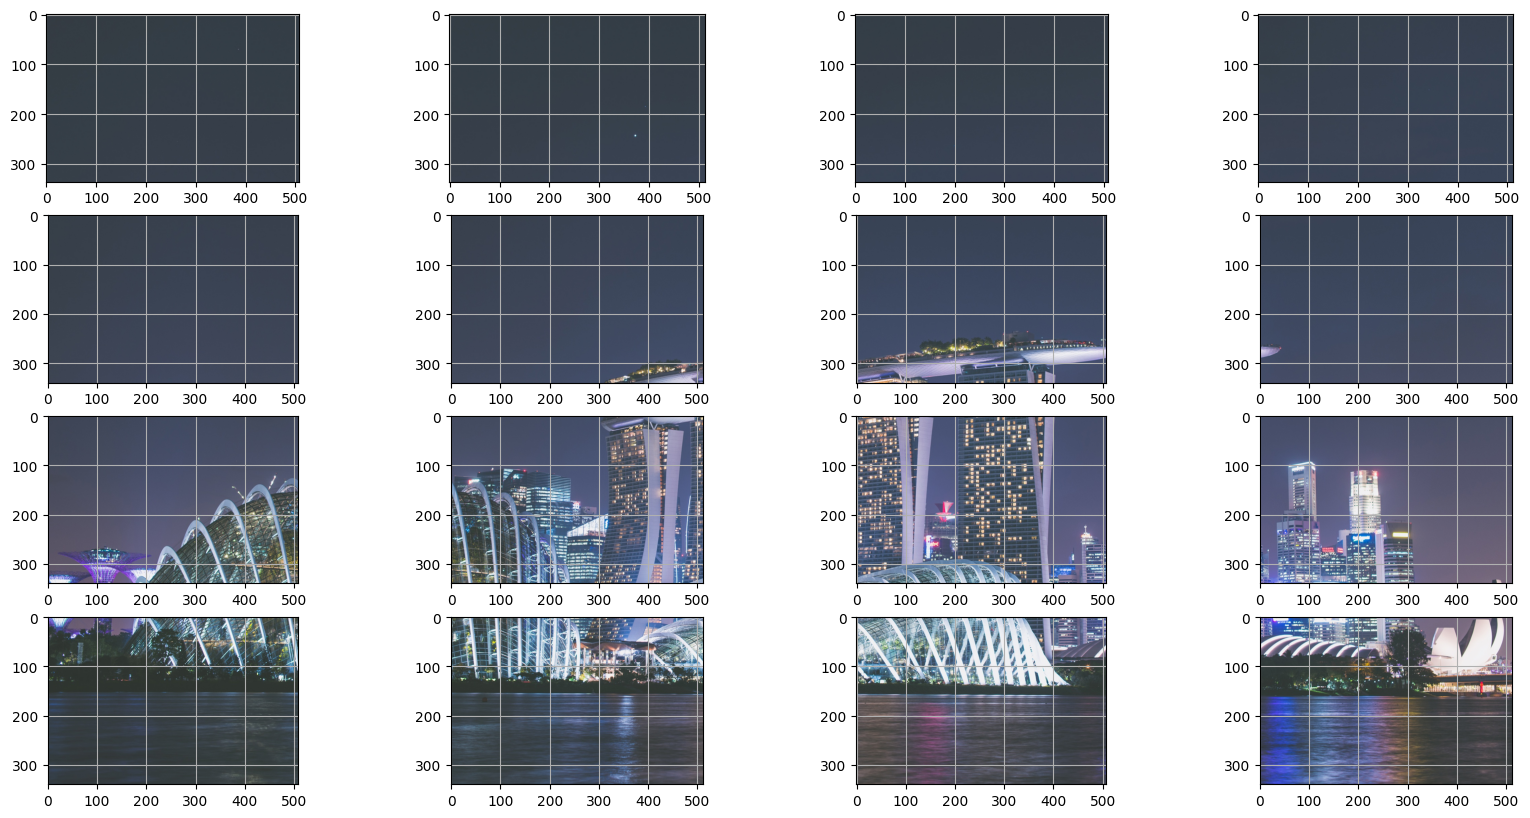

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_HR\DIV2K_valid_HR\0814.png')
img = torch.Tensor(img).permute(2,0,1)
x = Image_breakdown(img,lr=False)
rows = 4
columns = 4
fig = plt.figure(figsize=(20, 10))
for i in range(1,17):
    fig.add_subplot(rows, columns, i)
    x[i-1] = x[i-1].permute(1,2,0)
    print(x[i-1].shape)
    x[i-1] = x[i-1].cpu().detach().numpy()
    plt.imshow(x[i-1])
    plt.grid(visible=True)

torch.Size([84, 127, 3])
torch.Size([84, 128, 3])
torch.Size([84, 127, 3])
torch.Size([84, 128, 3])
torch.Size([85, 127, 3])
torch.Size([85, 128, 3])
torch.Size([85, 127, 3])
torch.Size([85, 128, 3])
torch.Size([85, 127, 3])
torch.Size([85, 128, 3])
torch.Size([85, 127, 3])
torch.Size([85, 128, 3])
torch.Size([85, 127, 3])
torch.Size([85, 128, 3])
torch.Size([85, 127, 3])
torch.Size([85, 128, 3])


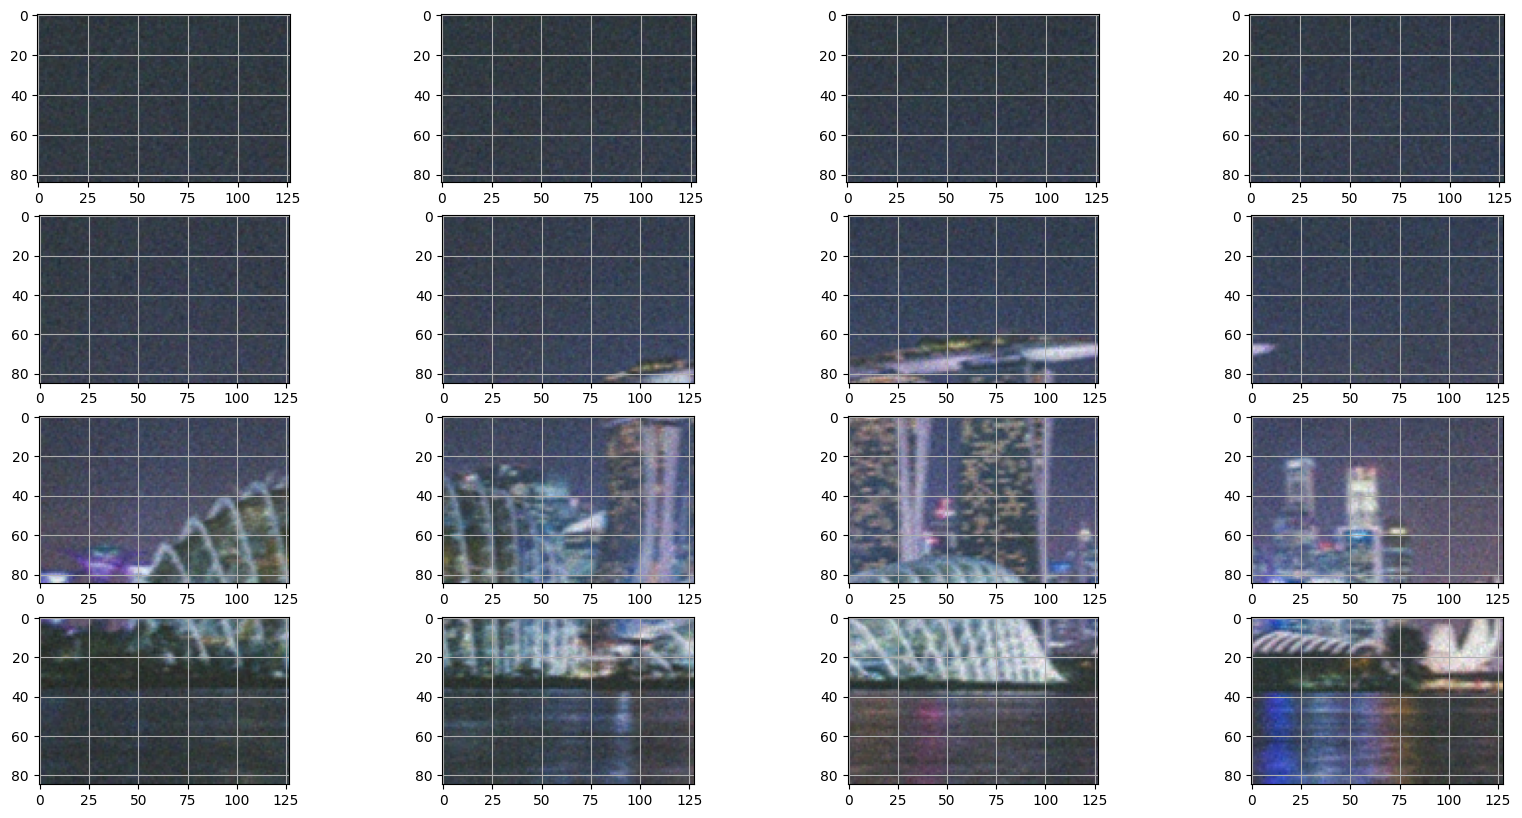

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_difficult\DIV2K_valid_LR_difficult\0814x4d.png')
img = torch.Tensor(img).permute(2,0,1)
x = Image_breakdown(img)
rows = 4
columns = 4
fig = plt.figure(figsize=(20, 10))
for i in range(1,17):
    fig.add_subplot(rows, columns, i)
    x[i-1] = x[i-1].permute(1,2,0)
    print(x[i-1].shape)
    x[i-1] = x[i-1].cpu().detach().numpy()
    plt.imshow(x[i-1])
    plt.grid(visible=True)

## **VGG-19 Pretrained on ImageNet-1k**

In [ ]:
class vgg_19_pretrained_ImageNet(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        vgg_19 = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        self.features = nn.ModuleList(list(vgg_19.features)).eval()
        
    def forward(self,x):
        
        results = []
        imp_features_of_vgg_19 = [5,12,22,32,42]
        for i,model in enumerate(self.features):
            x = model(x)
            if i in imp_features_of_vgg_19:
                results.append(torch.Tensor(x).cuda())
        
        return results

In [ ]:
prelu_init_value = 1
prelu_init_value1 = 10

## **GENERATOR**

In [ ]:
class Generator(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=9,stride=1,padding=4,padding_mode="reflect")
        self.res1 = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"),
                                  nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.res2 = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"),
                                  nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.res3 = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"),
                                  nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.res4 = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"),
                                  nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.res5a = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.res5b = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.conv2 = nn.Sequential(nn.PReLU(),nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"))
        self.upscale1 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=256, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"),
                                      nn.PixelShuffle(upscale_factor=2),
                                      nn.PReLU())
        self.upscale2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=256, kernel_size=3, stride=1, padding=1, groups=64, padding_mode="reflect"),
                                      nn.PixelShuffle(upscale_factor=2), 
                                      nn.PReLU())
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4,padding_mode="reflect")
        
    def forward(self,x):
        
        x = self.conv1(x)
        x1 = self.res1(x)
        x1 = torch.cat((x,x1),1)
        x1 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1).cuda()(x1)
        x2 = self.res2(x1)
        x2 = torch.cat((x1,x2),1)
        x2 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1).cuda()(x2)
        x3 = self.res3(x2)
        x3 = torch.cat((x2,x3),1)
        x3 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1).cuda()(x3)
        x4 = self.res4(x3)
        x4 = torch.cat((x3,x4),1)
        x4 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1).cuda()(x4)
        x5 = self.res5a(x4)
        x5 = self.res5b(x5)
        x5 = torch.cat((x,x5),1)
        x5 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1).cuda()(x5)
        x5 = self.conv2(x5)
        x = torch.add(x,x5)
        x = self.upscale1(x)
        x = self.upscale2(x)
        x = self.conv3(x)
        x = nn.Tanh()(x)
        
        return x       
        

In [ ]:
x = torch.rand((256,64,64))
x = nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=5,stride=2,padding=2,output_padding=1)(x)
x.shape

torch.Size([64, 128, 128])

## **DISCRIMINATOR**

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1,padding_mode="reflect"),
                                   nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1,groups=64,padding_mode="reflect"),
                                   nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=1,groups=64,padding_mode="reflect"),
                                   nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1,groups=64,padding_mode="reflect"),
                                   nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1,groups=128,padding_mode="reflect"),
                                   nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1,groups=128,padding_mode="reflect"),
                                   nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1,groups=256,padding_mode="reflect"),
                                   nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
       
        self.conv8 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1,groups=256,padding_mode="reflect"),
                                   nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.conv9 = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1,groups=512,padding_mode="reflect"),
                                   nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        
        self.fc_layer1 = nn.Sequential(nn.Linear(in_features=512*2*2, out_features=1024), nn.LeakyReLU(0.2))
        self.fc_layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=1), nn.Sigmoid())
        
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x1 = self.conv4(x)
        x1 = self.conv5(x1)
        
        x2 = self.conv6(x1)
        x2 = self.conv7(x2)
        
        x3 = self.conv8(x2)
        x3 = self.conv9(x3)
        
        x4 = nn.AvgPool2d(kernel_size=(x3.shape[2]//2,x3.shape[3]//2))(x3)
        x4 = x4.view(x4.shape[0],512*2*2)
        x4 = self.fc_layer1(x4)
        x4 = self.fc_layer2(x4)
        
        return x4

In [ ]:
x = torch.rand((1,3,245,242))
x = Discriminator()(x)
x.shape

torch.Size([1, 1])

##### To generate the location of the image on device

In [ ]:
def gen_random_numbers_in_range(low, high, n):
    
    x = random.sample(range(low, high), n)
    img_loc_hr = []
    img_loc_lr = []
    for i in x:
        i = str(i)
        if len(i) == 1:
            img_loc_hr.append("000" + i + ".png")
            img_loc_lr.append("000" + i + "x4d.png")
        elif len(i) == 2:
            img_loc_hr.append("00" + i + ".png")
            img_loc_lr.append("00" + i + "x4d.png")
        elif len(i) == 3:
            img_loc_hr.append("0" + i + ".png")
            img_loc_lr.append("0" + i + "x4d.png")
        
    return img_loc_hr, img_loc_lr

### Initializing the Generator and Discriminator

In [ ]:
generator = Generator().cuda()
try:
    if load_saved_model:
        generator.load_state_dict(torch.load('C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\GeneratorSRGAN.pth'))
        print("Loading the saved model...")
    else:
        generator.load_state_dict(torch.load('C:\\Users\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorSRGAN.pth'))
except:
    print("Initializing with uniform distribution...")
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    generator.apply(weights_init)

Initializing with uniform distribution...


In [ ]:
discriminator = Discriminator().cuda()
try:
    if load_saved_model:
        discriminator.load_state_dict(torch.load('C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorSRGAN.pth'))
        print("Loading the saved model...")
    else:
        discriminator.load_state_dict(torch.load('C:\\Users\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorSRGAN.pth'))
except:
    print("Initializing with uniform distribution...")
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    discriminator.apply(weights_init)

Initializing with uniform distribution...


In [ ]:
vgg_19 = vgg_19_pretrained_ImageNet().cuda()

### Inititalizing the Optimizers and the loss function

In [ ]:
optimizerGenerator = torch.optim.Adam(generator.parameters(),lr = 1e-4)
optimizerDisciminator = torch.optim.Adam(discriminator.parameters(),lr = 1e-4)
lr_scheduler_generator = torch.optim.lr_scheduler.StepLR(optimizer=optimizerGenerator,step_size=3,gamma=0.75)
lr_scheduler_discriminator = torch.optim.lr_scheduler.StepLR(optimizer=optimizerDisciminator,step_size=3,gamma=0.75)

loss_1 = nn.BCELoss()
loss_2 = nn.MSELoss()

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    
# Apply this right before loss.backwards() and before optimizer.step() to check the gradient flow of your network

##### Pre-Train the generator network to learn to produce outputs and then proceed training it along with the discriminator

In [ ]:
def pre_train(num_epochs):
    path_for_train_hr = "C:\\Users\\get2b\\Desktop\\Arav\\AI ML\\DATA SETS\\Generative AI dataset DIV2K\\DIV2K_train_HR\\DIV2K_train_HR\\"
    path_for_train_lr = "C:\\Users\\get2b\\Desktop\\Arav\\AI ML\\DATA SETS\\Generative AI dataset DIV2K\\DIV2K_train_LR_difficult\\DIV2K_train_LR_difficult\\"
    
    G_losses = []
    D_losses = []

    hr_target = torch.Tensor([[0.9]]).cuda()     # High Resolution Target
    sr_target = torch.Tensor([[0.0]]).cuda()    # Low Resolution Target
    
    generator.train()
    
    for epoch in range(0,num_epochs):
        
        print("Epoch : ",epoch)
        img_loc_hr, img_loc_lr = gen_random_numbers_in_range(1, 800, 100)
        
        for j in range(0,100):
            
            hr_img_path = path_for_train_hr + img_loc_hr[j]
            lr_img_path = path_for_train_lr + img_loc_lr[j] 
            
            hr_img = plt.imread(hr_img_path)
            hr_img = torch.Tensor(hr_img).cuda().permute(2,0,1)
            '''hr_img = torchvision.transforms.Normalize((0.5,), (0.5,)).cuda()(hr_img)'''
            hr_img = Image_breakdown(hr_img,lr=False)
            
            lr_img = cv2.imread(lr_img_path)
            lr_img = torch.Tensor(lr_img).cuda().permute(2,0,1)
            '''lr_img = torchvision.transforms.Normalize((0.5,), (0.5,)).cuda()(lr_img)'''
            lr_img = Image_breakdown(lr_img,lr=True)
            
            for i in range(0,16):
                
                ### Training the generator ###
                optimizerGenerator.zero_grad(set_to_none=False)
                sr_img = generator(lr_img[i].unsqueeze(0))
                vgg_maps_sr = vgg_19(sr_img)
                vgg_maps_hr = vgg_19(hr_img[i].unsqueeze(0))
                loss_mse_1 = loss_2(vgg_maps_sr[0],vgg_maps_hr[0])
                loss_mse_2 = loss_2(vgg_maps_sr[1],vgg_maps_hr[1])
                loss_mse_3 = loss_2(vgg_maps_sr[2],vgg_maps_hr[2])
                loss_mse_4 = loss_2(vgg_maps_sr[3],vgg_maps_hr[3])
                loss_mse_5 = loss_2(vgg_maps_sr[4],vgg_maps_hr[4])
                OverallLoss = loss_mse_1 + loss_mse_2 + loss_mse_3 + loss_mse_4 + loss_mse_5
                OverallLoss.backward()
                
                '''nn.utils.clip_grad.clip_grad_value_(generator.parameters(),1e-1)'''
                plot_grad_flow(generator.named_parameters())
                
                optimizerGenerator.step()
                
            if j%10 == 0:
                print('[%d/%d]\t[%d/%d]\tLoss_SR_VGG-Generator: %.4f'
                % (epoch, num_epochs, j, 100, OverallLoss.item()))

In [ ]:
def train(num_epochs):
    
    path_for_train_hr = "C:\\Users\\get2b\\Desktop\\Arav\\AI ML\\DATA SETS\\Generative AI dataset DIV2K\\DIV2K_train_HR\\DIV2K_train_HR\\"
    path_for_train_lr = "C:\\Users\\get2b\\Desktop\\Arav\\AI ML\\DATA SETS\\Generative AI dataset DIV2K\\DIV2K_train_LR_difficult\\DIV2K_train_LR_difficult\\"
    
    G_losses = []
    D_losses = []

    hr_target = torch.Tensor([[0.9]]).cuda()     # High Resolution Target
    sr_target = torch.Tensor([[0.0]]).cuda()    # Low Resolution Target
    
    generator.train()
    
    for epoch in range(0,num_epochs):
        
        print("Epoch : ",epoch)
        img_loc_hr, img_loc_lr = gen_random_numbers_in_range(1, 800, 100)
        
        for j in range(0,100):
            
            hr_img_path = path_for_train_hr + img_loc_hr[j]
            lr_img_path = path_for_train_lr + img_loc_lr[j] 
            
            hr_img = plt.imread(hr_img_path)
            hr_img = torch.Tensor(hr_img).cuda().permute(2,0,1)
            '''hr_img = torchvision.transforms.Normalize((0.5,), (0.5,)).cuda()(hr_img)'''
            hr_img = Image_breakdown(hr_img,lr=False)
            
            lr_img = cv2.imread(lr_img_path)
            lr_img = torch.Tensor(lr_img).cuda().permute(2,0,1)
            '''lr_img = torchvision.transforms.Normalize((0.5,), (0.5,)).cuda()(lr_img)'''
            lr_img = Image_breakdown(lr_img,lr=True)
            
            for i in range(0,16):
                
                ### Training the discriminator ###
                optimizerDisciminator.zero_grad(set_to_none=False)
                sr_img = generator(lr_img[i].unsqueeze(0)).detach()
                # sr_img = sr_img + torch.Tensor(np.random.uniform(0.0,0.5,sr_img.size())).cuda()   Not using this unless my model doesnt learn properly
                '''output = discriminator(sr_img.unsqueeze(0) + torch.Tensor(np.random.uniform(0.0,0.5,sr_img.size())).cuda())[4]'''
                output = discriminator(sr_img)
                super_reso_loss = loss_1(output[4],sr_target)
                sr_loss = super_reso_loss.item()
                super_reso_loss.backward()
                
                # hr_img = hr_img + torch.Tensor(np.random.uniform(0.0,0.5,hr_img.size())).cuda()   Not using this unless my model doesnt learn properly
                '''output = discriminator(hr_img[i].unsqueeze(0).cuda() + torch.Tensor(np.random.uniform(0.0,0.5,hr_img[i].size())).cuda())[4]'''
                output = discriminator(hr_img[i].unsqueeze(0).cuda())
                high_reso_loss = loss_1(output[4],hr_target)
                hr_loss = high_reso_loss.item()
                high_reso_loss.backward()
                
                optimizerDisciminator.step()
                
                
                ### Training the generator ###
                optimizerGenerator.zero_grad(set_to_none=False)
                sr_img = generator(lr_img[i].unsqueeze(0))
                vgg_maps_sr = vgg_19(sr_img)
                vgg_maps_hr = vgg_19(hr_img[i].unsqueeze(0))
                loss_mse_1 = loss_2(vgg_maps_sr[0],vgg_maps_hr[0])
                loss_mse_2 = loss_2(vgg_maps_sr[1],vgg_maps_hr[1])
                loss_mse_3 = loss_2(vgg_maps_sr[2],vgg_maps_hr[2])
                loss_mse_4 = loss_2(vgg_maps_sr[3],vgg_maps_hr[3])
                loss_mse_5 = loss_2(vgg_maps_sr[4],vgg_maps_hr[4])
                discriminator_loss = discriminator(sr_img)
                loss_bce_1 = loss_1(discriminator,sr_target)
                OverallLoss = loss_mse_1 + loss_mse_2 + loss_mse_3 + loss_mse_4 + loss_mse_5 + discriminator_loss
                OverallLoss.backward()
                
                '''nn.utils.clip_grad.clip_grad_value_(generator.parameters(),1e-1)'''
                '''plot_grad_flow(generator.named_parameters())'''
                
                optimizerGenerator.step()
                
            if j%10 == 0:
                print('[%d/%d]\t[%d/%d]\tLoss_SR_VGG-Generator: %.4f'
                % (epoch, num_epochs, j, 100, OverallLoss.item()))
                
            # Save Losses for plotting later
            G_losses.append(sr_loss)
            D_losses.append(hr_loss)

Epoch :  0
[0/20]	[0/100]	Loss_SR_VGG-Generator: 0.0238
[0/20]	[10/100]	Loss_SR_VGG-Generator: 0.0292
[0/20]	[20/100]	Loss_SR_VGG-Generator: 0.0482
[0/20]	[30/100]	Loss_SR_VGG-Generator: 0.0252
[0/20]	[40/100]	Loss_SR_VGG-Generator: 0.0345
[0/20]	[50/100]	Loss_SR_VGG-Generator: 0.0105
[0/20]	[60/100]	Loss_SR_VGG-Generator: 0.0084
[0/20]	[70/100]	Loss_SR_VGG-Generator: 0.0488
[0/20]	[80/100]	Loss_SR_VGG-Generator: 0.0288
[0/20]	[90/100]	Loss_SR_VGG-Generator: 0.0117
Epoch :  1
[1/20]	[0/100]	Loss_SR_VGG-Generator: 0.0472
[1/20]	[10/100]	Loss_SR_VGG-Generator: 0.0257
[1/20]	[20/100]	Loss_SR_VGG-Generator: 0.0037
[1/20]	[30/100]	Loss_SR_VGG-Generator: 0.0226
[1/20]	[40/100]	Loss_SR_VGG-Generator: 0.0173
[1/20]	[50/100]	Loss_SR_VGG-Generator: 0.0325
[1/20]	[60/100]	Loss_SR_VGG-Generator: 0.0170
[1/20]	[70/100]	Loss_SR_VGG-Generator: 0.0053
[1/20]	[80/100]	Loss_SR_VGG-Generator: 0.0365
[1/20]	[90/100]	Loss_SR_VGG-Generator: 0.0181
Epoch :  2
[2/20]	[0/100]	Loss_SR_VGG-Generator: 0.0509
[2/2

KeyboardInterrupt: 

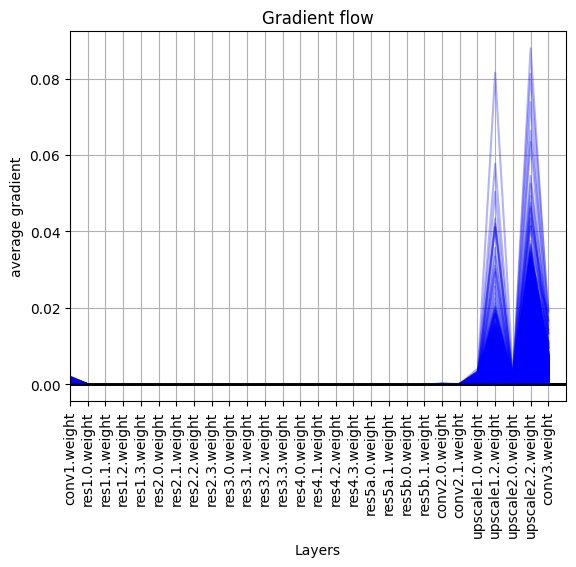

In [ ]:
pre_train(20)

Epoch :  0
[0/1]	[0/100]	HR_Loss_D: 0.6534	SR_Loss_D: 0.5983	Loss_SR-Generator: 4.0376
[0/1]	[10/100]	HR_Loss_D: 0.3530	SR_Loss_D: 0.3165	Loss_SR-Generator: 4.4675
[0/1]	[20/100]	HR_Loss_D: 0.3699	SR_Loss_D: 0.1150	Loss_SR-Generator: 5.7938


KeyboardInterrupt: 

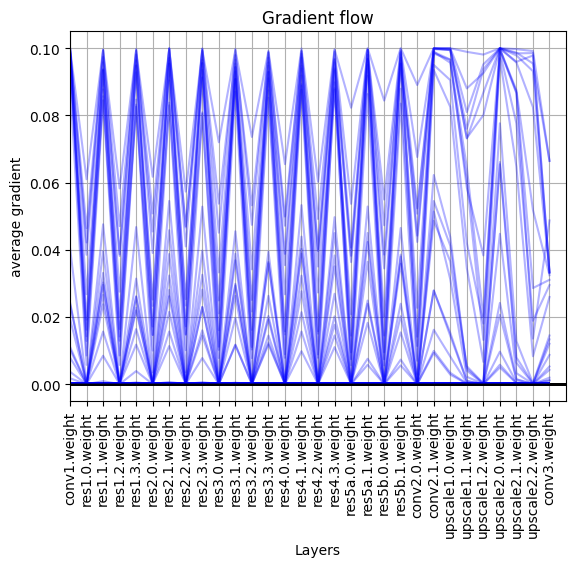

In [ ]:
train(0)

(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)
(384, 508, 3)
(384, 512, 3)


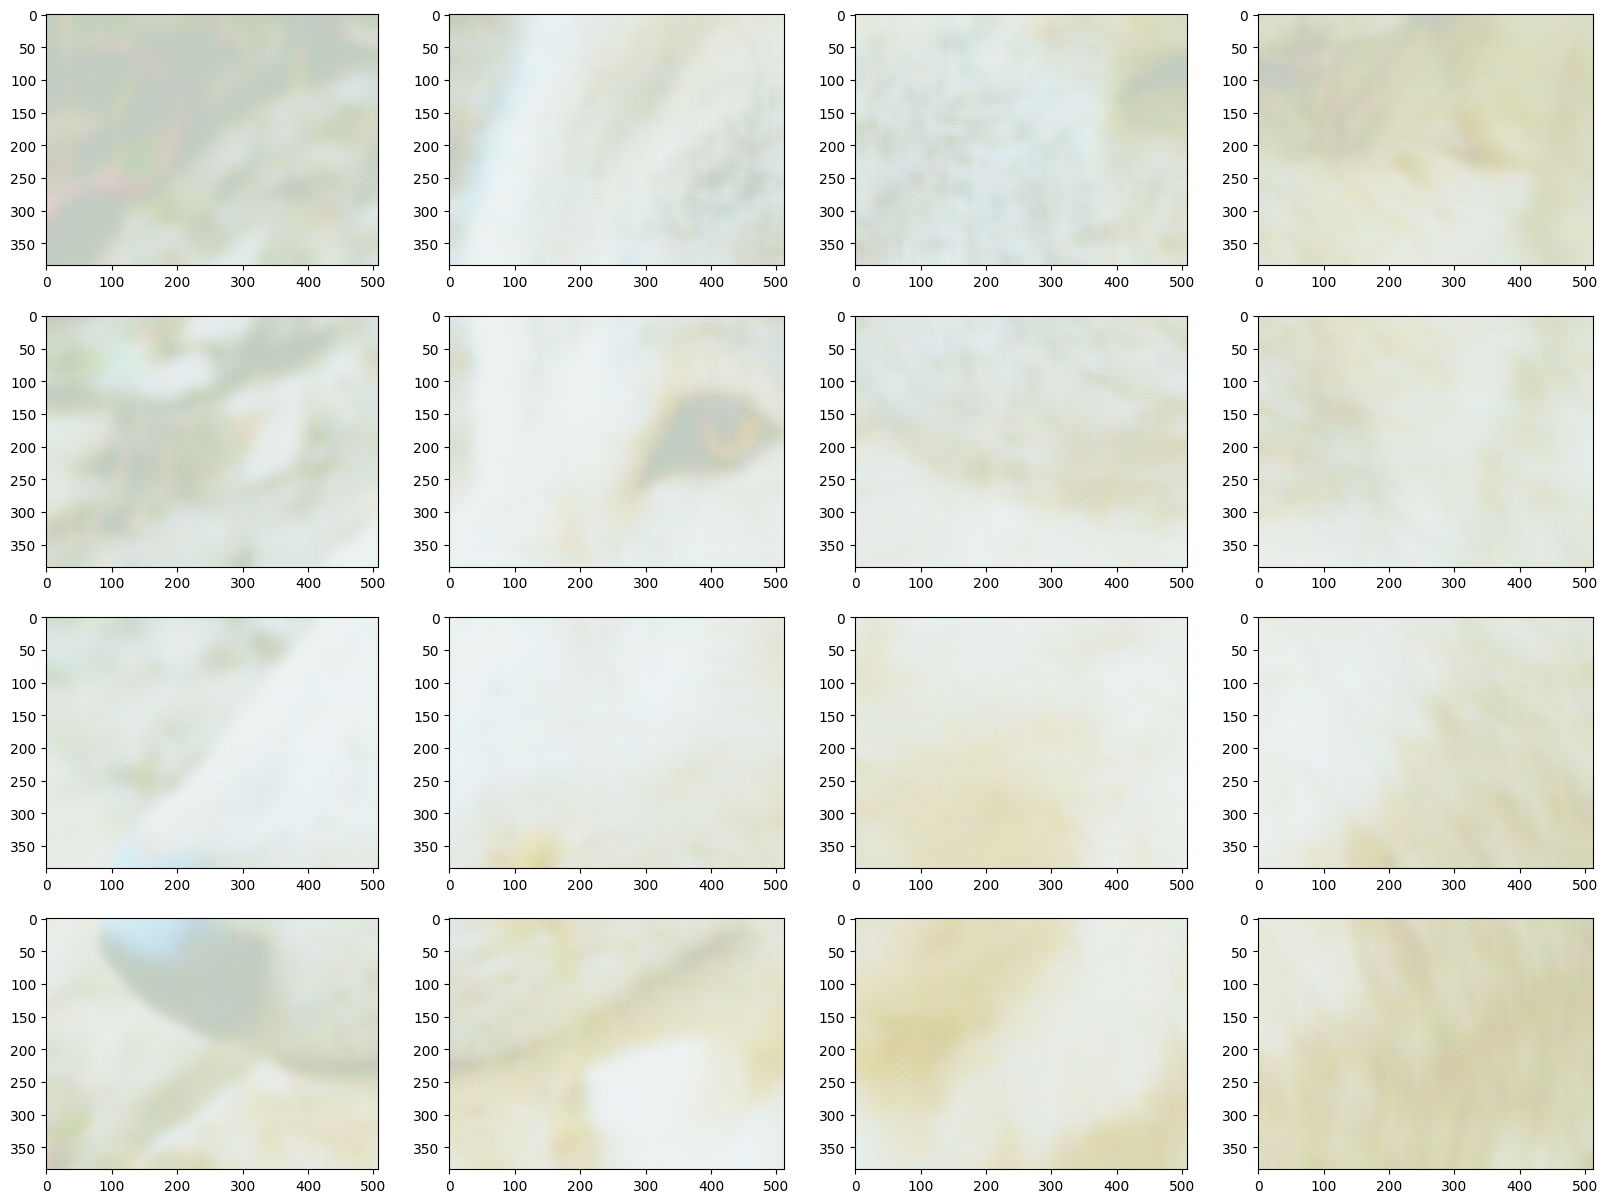

In [ ]:
def verifying():
    generator.eval()
    path_for_valid_lr = "C:\\Users\\get2b\\Desktop\\Arav\\AI ML\\DATA SETS\\Generative AI dataset DIV2K\\\DIV2K_valid_LR_difficult\\DIV2K_valid_LR_difficult\\0805x4d.png"
    lr_img = cv2.imread(path_for_valid_lr)
    lr_img = torch.Tensor(lr_img).cuda().permute(2,0,1)
    #lr_img = torchvision.transforms.Normalize((0.5,), (0.5,)).cuda()(lr_img)
    lr_img = Image_breakdown(lr_img,lr=True)
    sr_img = []
    for i in range(0,16):
        sr_img.append(generator(lr_img[i].unsqueeze(0)))
    x = sr_img
    rows = 4
    columns = 4
    fig = plt.figure(figsize=(20, 15))
    for i in range(1,17):
        fig.add_subplot(rows, columns, i)
        x[i-1] = x[i-1].permute(0,2,3,1)
        x[i-1] = x[i-1].cpu().detach().numpy()
        print(x[i-1][0].shape)
        plt.imshow(x[i-1][0])
        plt.grid(visible=False)
verifying()

torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])
torch.Size([96, 127, 3])
torch.Size([96, 128, 3])


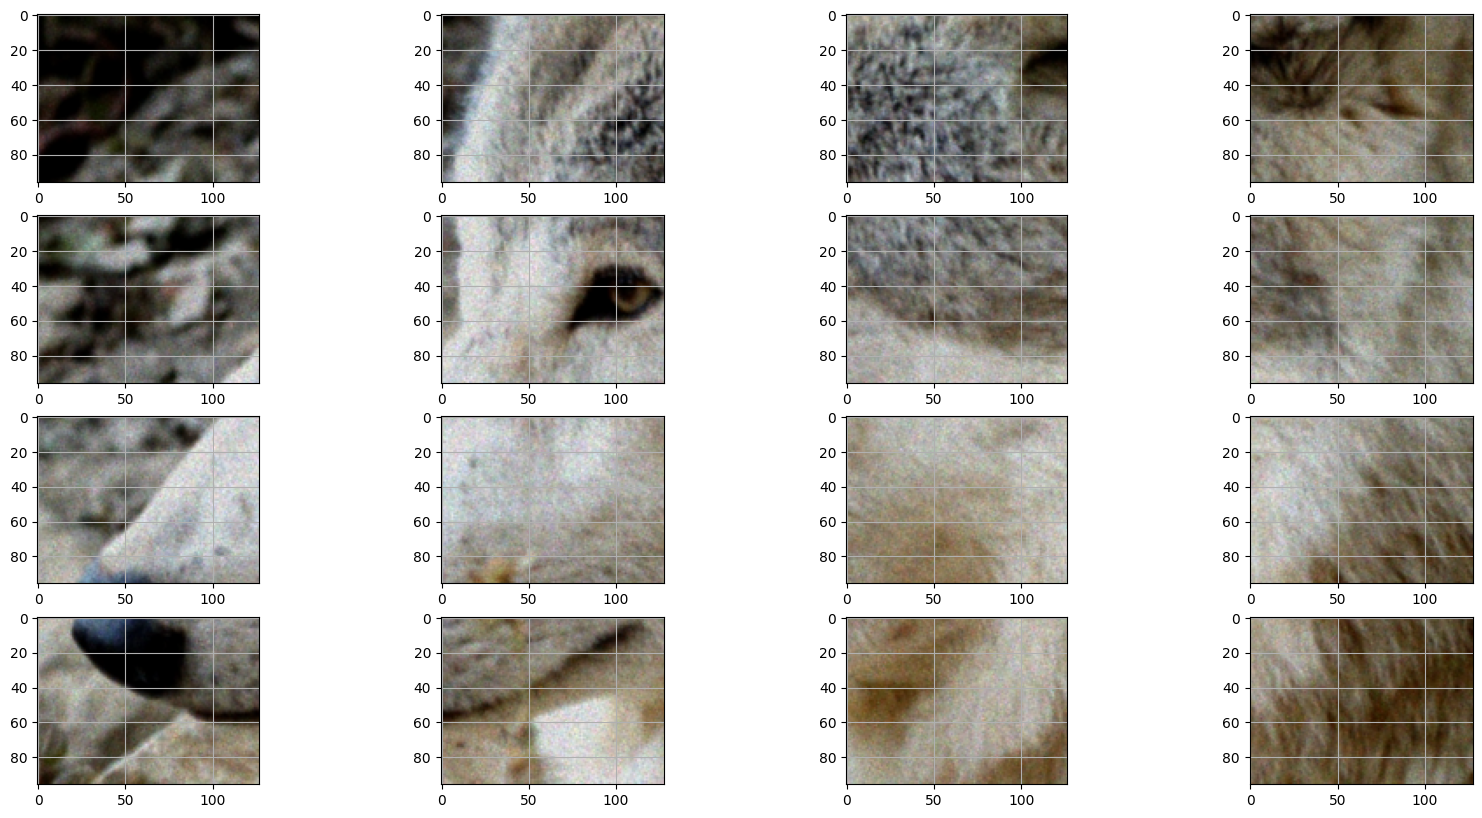

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_LR_difficult\DIV2K_valid_LR_difficult\0805x4d.png')
img = torch.Tensor(img).permute(2,0,1)
x = Image_breakdown(img)
rows = 4
columns = 4
fig = plt.figure(figsize=(20, 10))
for i in range(1,17):
    fig.add_subplot(rows, columns, i)
    x[i-1] = x[i-1].permute(1,2,0)
    print(x[i-1].shape)
    x[i-1] = x[i-1].cpu().detach().numpy()
    plt.imshow(x[i-1])
    plt.grid(visible=True)

torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])
torch.Size([384, 508, 3])
torch.Size([384, 512, 3])


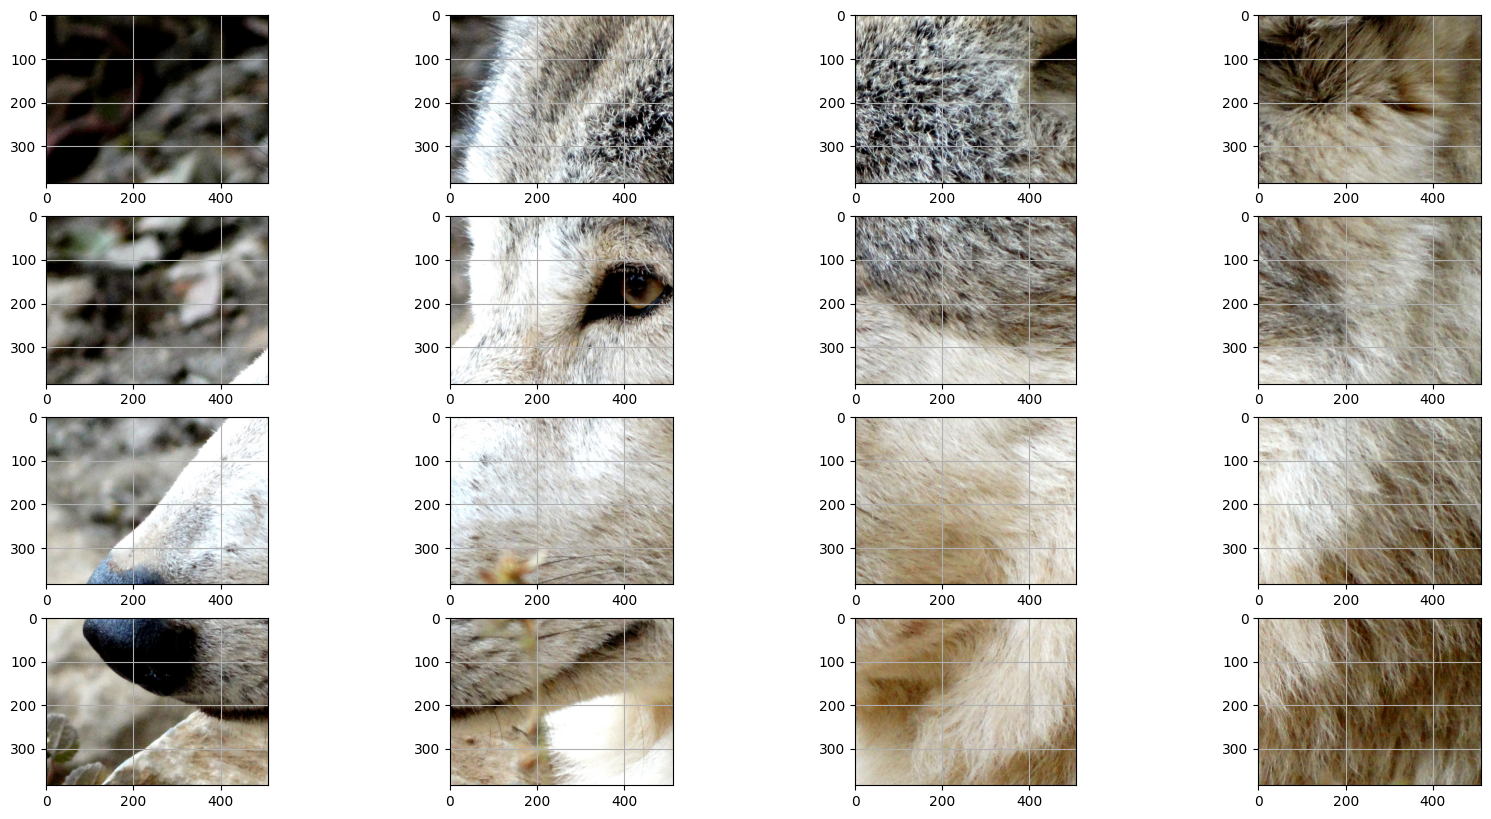

In [ ]:
img = plt.imread(r'C:\Users\get2b\Desktop\Arav\AI ML\DATA SETS\Generative AI dataset DIV2K\DIV2K_valid_HR\DIV2K_valid_HR\0805.png')
img = torch.Tensor(img).permute(2,0,1)
x = Image_breakdown(img,lr=False)
rows = 4
columns = 4
fig = plt.figure(figsize=(20, 10))
for i in range(1,17):
    fig.add_subplot(rows, columns, i)
    x[i-1] = x[i-1].permute(1,2,0)
    print(x[i-1].shape)
    x[i-1] = x[i-1].cpu().detach().numpy()
    plt.imshow(x[i-1])
    plt.grid(visible=True)

In [ ]:
torch.save(generator.state_dict(), 'C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\GeneratorSRGAN.pth')
torch.save(discriminator.state_dict(), 'C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorSRGAN.pth')